In [1]:
import joblib
import os
from numpy.linalg import inv
from API.utils import *
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

In [2]:
os.listdir('./model')

['ANN(58_to_sp162(二合一)).pkl',
 'ANN(58_to_sp162).pkl',
 'ANN(58_to_y162(二合一)).pkl',
 'ANN(58_to_y162).pkl',
 'ANN(energy).pkl',
 'ANN(tray).pkl',
 'eva.pkl',
 'OperationOptimModel.pkl',
 'SVR(4_to_23).pkl',
 'transformer(23_to_54).pkl',
 'transformer(33_to_15).pkl',
 'transformer(43_to_33).pkl',
 'transformer(54_to_23).pkl',
 'transformer(54_to_33).pkl',
 'transformer(SP162_to_Y162).pkl']

In [3]:
os.listdir('./data/phase_2/cleaned')

['col_names.pkl', 'train(energy).csv', 'train.csv', '現場數據.csv']

In [4]:
f = joblib.load('./model/ANN(58_to_sp162).pkl')
g = joblib.load('./model/ANN(energy).pkl')

In [5]:
df = pd.read_csv('./data/phase_2/cleaned/train.csv').sample(1000)
col = joblib.load('./data/phase_2/cleaned/col_names.pkl')

In [6]:
X = df[col['case']+col['xna']]
wt = df[col['xle']+col['xhc']+col['xhe']]

In [7]:
sp_pred = f.predict(X)
g_pred = g.predict(X)

[[9.99395967e-01 4.55298752e-04 3.08944524e-04 ... 3.50308314e-04
  1.91686282e-04 9.99618411e-01]
 [9.99715149e-01 3.48558213e-04 2.86095339e-04 ... 4.10808017e-04
  2.72690697e-04 9.99477208e-01]
 [9.99782979e-01 1.11051886e-04 1.83729542e-04 ... 2.05284843e-04
  2.41706366e-04 9.99829888e-01]
 ...
 [9.99812782e-01 2.59777182e-04 3.02670553e-04 ... 3.18697596e-04
  2.99092906e-04 9.99742448e-01]
 [9.99843597e-01 1.23238409e-04 1.73198801e-04 ... 1.53031491e-04
  1.94661261e-04 9.99818146e-01]
 [9.99842048e-01 1.61278003e-04 2.13379128e-04 ... 2.04743177e-04
  2.31506885e-04 9.99802053e-01]]
     Individual Component to Light End Split Factor_Oxygen_Ratio  \
0                                             0.999236             
1                                             0.999366             
2                                             0.999705             
3                                             0.999146             
4                                             0.998904      

In [8]:
xna = X[col['xna']]

sle = sp_pred[col['sle']]
rle = g_pred['rle']

shc = sp_pred[col['shc']]
rhc = g_pred['rhc']

she = sp_pred[col['she']]
rhe = g_pred['rhe']

In [31]:
rle+rhc+rhe

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
995    1.0
996    1.0
997    1.0
998    1.0
999    1.0
Length: 1000, dtype: float32

In [9]:
fhc_m3 = X['Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr']
fhc_ton = fhc_m3*g_pred['HC_density']
fna_ton = fhc_ton * 1/rhc
fle_ton = fna_ton * rle
fhe_ton = fna_ton * rhe

In [10]:
xle_ = xna.values*sle.values / rle.values.reshape(-1,1)
xhc_ = xna.values*shc.values / rhc.values.reshape(-1,1)
xhe_ = xna.values*she.values / rhe.values.reshape(-1,1)

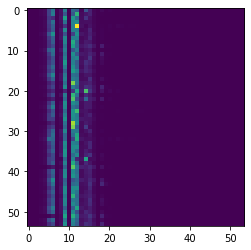

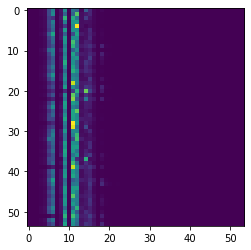

In [11]:
import matplotlib.pyplot as plt

plt.imshow(xle_[:54])
plt.show()
plt.imshow(wt[col['xle']].values[:54])

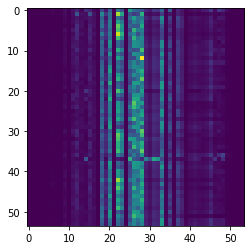

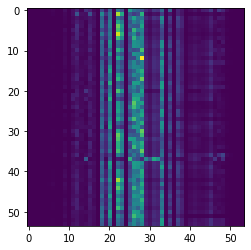

In [12]:
plt.imshow(xhc_[:54])
plt.show()
plt.imshow(wt[col['xhc']].values[:54])

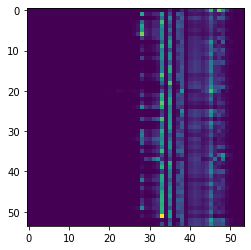

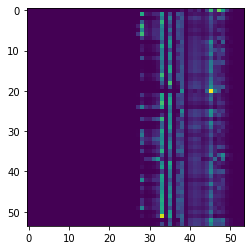

In [13]:
plt.imshow(xhe_[:54])
plt.show()
plt.imshow(wt[col['xhe']].values[:54])

In [14]:
from sklearn.metrics import mean_squared_error,r2_score

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

t = pd.DataFrame(index=[0],columns=['R2','MSE','MAPE'])
a = np.hstack((xle_,xhc_,xhe_))
b = np.hstack((wt[col['xle']],wt[col['xhc']],wt[col['xhe']]))

t['R2'] = r2_score(a,b)
t['MSE'] = mean_squared_error(a,b)
t['MAPE'] = mape(a,b)
t

,R2,MSE,MAPE
0,0.482198,0.056409,NaN


In [17]:
c6_col = col['xhc'][3:8] + col['xhc'][9:12]
c7_col = ['Light End Product Properties_2,2-Dimethylpentane_wt%']+col['xle'][16:]

In [ ]:
xle_ = pd.DataFrame(xle_,columns=col['xle'])
xle_[c7_col].sum(axis=1),wt[col['xle']][c7_col].sum(axis=1)

In [30]:
a = xhc_ = pd.DataFrame(xhc_,columns=col['xhc'])
a,b = xhc_[c6_col].sum(axis=1),wt[col['xhc']][c6_col].sum(axis=1)
t = pd.DataFrame()
t['真實'] = b.values
t['預測'] = a.values
print('c6p-')
t

c6p-


,真實,預測
0,1.944595,1.987722
1,1.465903,1.556749
2,0.977560,1.082213
3,0.990726,1.055563
4,0.493656,0.460545
...,...,...
995,1.473703,1.527463
996,0.974946,0.996815
997,1.969427,2.086943
998,1.479809,1.550542


In [29]:
a = xle_ = pd.DataFrame(xle_,columns=col['xle'])
a,b = xle_[c7_col].sum(axis=1),wt[col['xle']][c7_col].sum(axis=1)
t = pd.DataFrame()
t['真實'] = b.values
t['預測'] = a.values
print('c7p')
t

c7p


,真實,預測
0,2.499746,3.252318
1,2.499913,2.758878
2,2.499996,2.571543
3,2.499998,3.829187
4,2.499724,6.444054
...,...,...
995,5.000083,5.062120
996,10.000364,9.531976
997,4.999687,5.044288
998,2.500009,2.670977
